In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline
import random

In [2]:
import torchvision
import torchvision.transforms as transforms

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available now:', device)

Device available now: cuda


In [4]:
image_transforms = transforms.Compose(
         [transforms.ToTensor(),
         transforms.CenterCrop(28),
         transforms.Normalize((0.5), (0.5))]
)

In [5]:
batchsize = 32
rowsize = 28
colsize = 28
inchannels = 3
kernelsize = 5
stride = 1
padding = 0
poolsize = 3
fc_size1 = 384
fc_size2 = 192
no_classes = 10
epochs = 40
overfit_accuracy = 90

In [6]:
alex_overfitcounts = []
alex_testaccuracies = []

In [7]:
train = torchvision.datasets.CIFAR10(root='./', train=True, download=True, transform=image_transforms)
test = torchvision.datasets.CIFAR10(root='./', train=False, transform=image_transforms)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./


In [8]:
trainindices = list(range(0, len(train), 10))
testindices = list(range(0, len(test),10))
trainset = torch.utils.data.Subset(train,trainindices)
testset = torch.utils.data.Subset(test,testindices)

In [9]:
traindata = torch.utils.data.DataLoader(trainset,batch_size=batchsize, shuffle=False, num_workers=2,pin_memory=True)
testdata = torch.utils.data.DataLoader(testset,batch_size=batchsize, shuffle=False, num_workers=2,pin_memory=True)

In [10]:
train_labels = torch.zeros(len(traindata)*batchsize)
test_labels = torch.zeros(len(testdata)*batchsize)
trainnum = 0
testnum = 0
for i,data in enumerate(traindata):
  for j in range(len(data[1])):
    train_labels[trainnum] = data[1][j]
    trainnum+=1
for i,data in enumerate(testdata):
  for j in range(len(data[1])):
    test_labels[testnum] = data[1][j]
    testnum+=1
  

In [11]:
class SimpleAlex(nn.Module):
  def __init__(self,inchannels,kernelsize,stride,padding,poolsize,fc_size1,fc_size2,no_classes):
    super(SimpleAlex, self).__init__()
    self.conv1 = nn.Conv2d(inchannels,24,kernelsize,stride,padding)
    self.pool1 = nn.MaxPool2d(poolsize,2)
    self.BatchNorm1 = nn.BatchNorm2d(24)
    self.conv2 = nn.Conv2d(24,48,kernelsize,stride,padding)
    self.pool2 = nn.MaxPool2d(poolsize,2)
    self.BatchNorm2 = nn.BatchNorm2d(48)
    self.fc1 = nn.Linear(432,fc_size1)
    self.fc2 = nn.Linear(fc_size1,fc_size2)
    self.fc3 = nn.Linear(fc_size2,no_classes) 

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = self.BatchNorm1(x)
    x = F.relu(self.conv2(x))
    x = self.pool2(x)
    x = self.BatchNorm2(x)
    x = torch.flatten(x,1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    return x

In [12]:
model = SimpleAlex(inchannels,kernelsize,stride,padding,poolsize,fc_size1,fc_size2,no_classes).to(device)
# model = SimpleAlex(no_classes).to(device)

In [13]:
optimizer = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay = 0.005, momentum = 0.9)
criterion = nn.CrossEntropyLoss().to(device)

In [14]:
import random
randompixels = np.random.rand(batchsize*3*rowsize*colsize)
print(len(randompixels))

75264


In [15]:
def training(model,traindata,testdata,optimizer,train_labels,test_labels,var):
  ls = []
  test_accuracies = []
  test_accuracies.append(0)
  test_accuracies.append(0)
  test_accuracies.append(0)
  count=0
  flag=0
  prev = 0
  for ep in range(epochs):
    print("---")
    Loss = 0
    num_correct=0
    tot = 0
    pix_count = 0
    testnum = 0
    trainnum = 0
    for i,data in enumerate(traindata):
      # if we change the data here only when ep=1 then it would be sufficient 
      x_data = data[0].to(device)
      labels = data[1].to(device)
      if var==2:
        # Here the data is x_data
        pix_count=0
        for image in range(len(x_data)):
          for rgb in range(3):
            for r in range(rowsize):
              for c in range(colsize):
                x_data[image][rgb][r][c] = randompixels[pix_count]
                pix_count+=1
      for j in range(len(x_data)):
        labels[j] = train_labels[trainnum]
        trainnum+=1
      optimizer.zero_grad()
      outputs = model(x_data)
      _, pred = torch.max(outputs.data, 1)
      num_correct += (pred == labels).sum().item()
      tot += labels.size(0)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      Loss += loss
    ls.append(num_correct/tot)
    print("Accuracy : ",num_correct/tot)
    print("Loss : ",loss)
    with torch.no_grad():
      correct = 0
      total = 0
      for i,data in enumerate(testdata):
          images = data[0]
          labels = data[1]
          images = images.to(device)
          labels = labels.to(device)
          for j in range(len(images)):
             labels[j] = test_labels[testnum]
             testnum+=1
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item() 
      test_accuracies.append(100*correct/total)
      print("Accuracy of the on test images : ",100 * correct / total)
      count+=1
  return ls

In [16]:
true_accuracies = []
label_randaccuracies = []
shufflepixels_accuracies = []
randompixels_accuracies = []
gaussian_accuracies = []

In [17]:
true_accuracies = training(model,traindata,testdata,optimizer,train_labels,test_labels,0)

---
Accuracy :  0.2674
Loss :  tensor(1.7100, device='cuda:0', grad_fn=<NllLossBackward0>)
Accuracy of the on test images :  33.8
---
Accuracy :  0.4138
Loss :  tensor(1.3691, device='cuda:0', grad_fn=<NllLossBackward0>)
Accuracy of the on test images :  41.2
---
Accuracy :  0.485
Loss :  tensor(0.9932, device='cuda:0', grad_fn=<NllLossBackward0>)
Accuracy of the on test images :  46.3
---
Accuracy :  0.5494
Loss :  tensor(0.6750, device='cuda:0', grad_fn=<NllLossBackward0>)
Accuracy of the on test images :  48.1
---
Accuracy :  0.5974
Loss :  tensor(0.6128, device='cuda:0', grad_fn=<NllLossBackward0>)
Accuracy of the on test images :  49.0
---
Accuracy :  0.6438
Loss :  tensor(0.4533, device='cuda:0', grad_fn=<NllLossBackward0>)
Accuracy of the on test images :  48.3
---
Accuracy :  0.681
Loss :  tensor(0.2873, device='cuda:0', grad_fn=<NllLossBackward0>)
Accuracy of the on test images :  48.8
---
Accuracy :  0.7198
Loss :  tensor(0.2734, device='cuda:0', grad_fn=<NllLossBackward0>)
A

In [19]:
print(true_accuracies)

[0.2674, 0.4138, 0.485, 0.5494, 0.5974, 0.6438, 0.681, 0.7198, 0.7388, 0.7504, 0.7696, 0.7994, 0.82, 0.8296, 0.8428, 0.8594, 0.8932, 0.8912, 0.9014, 0.914, 0.922, 0.9282, 0.9238, 0.944, 0.9514, 0.9486, 0.96, 0.9618, 0.9686, 0.9752, 0.9744, 0.9728, 0.9712, 0.9734, 0.9562, 0.9208, 0.9362, 0.9442, 0.943, 0.9694]


In [20]:
model = SimpleAlex(inchannels,kernelsize,stride,padding,poolsize,fc_size1,fc_size2,no_classes).to(device)
# model = SimpleAlex(no_classes).to(device)

In [21]:
optimizer = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay = 0.005, momentum = 0.9)
criterion = nn.CrossEntropyLoss().to(device)

In [22]:
for i in range(len(train_labels)):
    train_labels[i] = random.randint(0,9)
for i in range(len(test_labels)):
    test_labels[i] = random.randint(0,9)

In [23]:
label_randaccuracies = training(model,traindata,testdata,optimizer,train_labels,test_labels,0)

---
Accuracy :  0.101
Loss :  tensor(2.3055, device='cuda:0', grad_fn=<NllLossBackward0>)
Accuracy of the on test images :  10.4
---
Accuracy :  0.1294
Loss :  tensor(2.2999, device='cuda:0', grad_fn=<NllLossBackward0>)
Accuracy of the on test images :  10.4
---
Accuracy :  0.1428
Loss :  tensor(2.2499, device='cuda:0', grad_fn=<NllLossBackward0>)
Accuracy of the on test images :  10.7
---
Accuracy :  0.1532
Loss :  tensor(2.2040, device='cuda:0', grad_fn=<NllLossBackward0>)
Accuracy of the on test images :  10.9
---
Accuracy :  0.165
Loss :  tensor(2.1486, device='cuda:0', grad_fn=<NllLossBackward0>)
Accuracy of the on test images :  10.4
---
Accuracy :  0.1714
Loss :  tensor(2.1142, device='cuda:0', grad_fn=<NllLossBackward0>)
Accuracy of the on test images :  9.8
---
Accuracy :  0.1788
Loss :  tensor(2.0154, device='cuda:0', grad_fn=<NllLossBackward0>)
Accuracy of the on test images :  10.5
---
Accuracy :  0.1856
Loss :  tensor(1.9152, device='cuda:0', grad_fn=<NllLossBackward0>)
Ac

In [24]:
print(label_randaccuracies)

[0.101, 0.1294, 0.1428, 0.1532, 0.165, 0.1714, 0.1788, 0.1856, 0.1914, 0.2048, 0.2302, 0.237, 0.252, 0.268, 0.2942, 0.309, 0.318, 0.3342, 0.3608, 0.3794, 0.396, 0.4322, 0.4372, 0.4708, 0.4874, 0.5236, 0.5494, 0.5624, 0.583, 0.6108, 0.6202, 0.6438, 0.6416, 0.6758, 0.6852, 0.7012, 0.709, 0.7178, 0.7442, 0.7726]


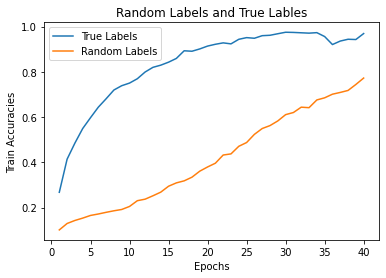

In [26]:
epochs = []
for i in range(40):
  epochs.append(i+1)
plt.plot(epochs,true_accuracies,label="True Labels")
plt.plot(epochs,label_randaccuracies,label="Random Labels")
plt.title("Random Labels and True Lables")
plt.xlabel("Epochs")
plt.ylabel("Train Accuracies")
plt.legend()
plt.show()